<a href="https://colab.research.google.com/github/shyKEN/Gather-Sprint-predict-group-3-/blob/master/Kaggle_Challenge_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=blue>Kaggle Classification Challenge Notebook

___

## Problem statement and Overview 

The purpose of this notebook is to show our workings as Team 5 for the Kaggle in-class challenge on perfoming sentiment analysis on tweets, particularly **predicting or classifying how a particular Twitter user feels about Climate Change based on their body of messgae/tweet**.<br>

##### Team 5 members:<br>
- Evans Marema
- Vinita Maharaj
- Gugu Mtonjeni
- Refentse Motlogelwa
- Sandile Dladla
- Sandile Mkize

For this challenge we were provided with two datasets(for taining and testing our models) and a sample submission 

- test.csv ---------------------------- Dataset to be used for predictions which will be accessed on Kaggle model
- train.csv --------------------------- Dataset to be use for training model
- sample_submission.csv ------ An Example of a submission file

Different `sentiment` classes types and their corrisponding descriptions

<img src="class_description.png">

___

In [4]:
# Import comet_ml for versioning
from comet_ml import Experiment

experiment = Experiment(api_key="toXXRULujXVmmXBW2zMcncxEI",
                        project_name="general", workspace="shyken")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/shyken/general/35fac7e46b2e475c9eb7d7596954e5e6



## Library imports

In [6]:
# For data manipulation and ploting
from matplotlib.pyplot import suptitle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pylab import rcParams
import numpy as np
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import spacy
import re

# For extracting features of twitter data e.g.@mentions
import advertools

# For importing images into the notebook 
from PIL import Image

# For Visaulising common/frequent words in text data
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For counting common/frequent words in text data
from collections import Counter

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import recall_score,f1_score,precision_score
import pickle

In [7]:
# For printing option and text color
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [9]:
# This is spacy corpus that wiil be used to extract extra info from data
nlp = spacy.load('en_core_web_sm')

## Loading Data

In [10]:
sub_df = pd.read_csv('https://raw.githubusercontent.com/REFENTSE-MOTLGELWA/classification-predict-streamlit-template/master/resource2/datasets/sample_submission.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/REFENTSE-MOTLGELWA/classification-predict-streamlit-template/master/resource2/datasets/test.csv')
test_df = test_df.set_index('tweetid')
train_df = pd.read_csv('https://raw.githubusercontent.com/REFENTSE-MOTLGELWA/classification-predict-streamlit-template/master/resource2/datasets/train.csv')
train_df = train_df.set_index('tweetid')

In [11]:
test_df.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos \nPuti...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


In [12]:
test_df.shape

(10546, 1)

In [13]:
train_df.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [14]:
train_df.shape

(15819, 2)

##  Exploditory Data Analysis 

In this section we take deep dive into our given data and try gain information and knowledge that will help us better understand our data and tackle this challenge. We explore the response `sentiments` and also the features `message` and try to understand their relationship.

In [15]:
print(f'Missing values in train dataset:\n'
      f'{train_df.isna().sum()}\n')
print(f'Missing values in test dataset:\n'
      f'{test_df.isna().sum()}')

Missing values in train dataset:
sentiment    0
message      0
dtype: int64

Missing values in test dataset:
message    0
dtype: int64


In [16]:
# Checking for Empty messages in both train and test datasets

blanks_test = []
for tID,msg in test_df.itertuples():
    if msg.isspace == True:
        blanks_test.append(tID)

blanks_train = []
for tID,sent,msg in train_df.itertuples():
    if msg.isspace == True:
        blanks_test.append(tID)

In [17]:
print(f'No. of empty messages in train: {len(blanks_train)}\n')
print(f'No. of empty messages in test: {len(blanks_test)}')

No. of empty messages in train: 0

No. of empty messages in test: 0


**Both the train and test datasets do not have nulls or empty strings** 

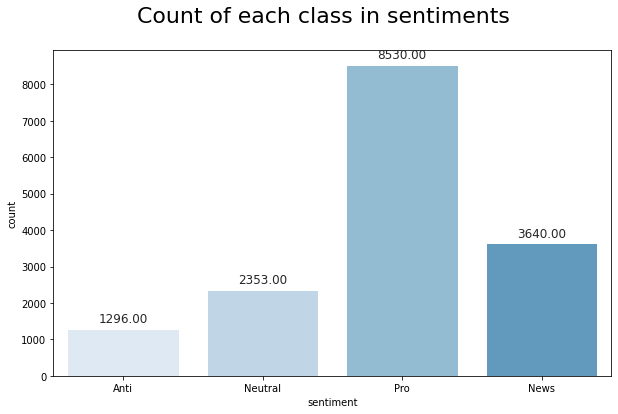

In [18]:
# Counting No. of elements in each classes in sentiment

f, ax = plt.subplots(figsize=(10,6))
labels = ['Anti','Neutral','Pro','News']
suptitle("Count of each class in sentiments",fontsize=22)
sns.set(style="darkgrid",palette='Blues')

count = sns.countplot(x='sentiment', data=train_df)
ax.set(xticks=range(4), xticklabels=labels)

for p in count.patches:
    ax.annotate(format(p.get_height(),'.2f'),
                   (p.get_x()+p.get_width() / 2.,p.get_height()),
                   ha='center',va='center',xytext=(0, 10),
                   textcoords='offset points')

From the plot we can easy observe that the `sentiment`  `Pro` class has a very high number of messages, it's size being 2 times that of the second highest ranking class. This could present a problem when modeling in a sense that models fitted on this data is more likely to predict the `Pro` with high accurary and perform poorly in predicting other classes. <br>

There are several solutions to this which are discussedin detail <a href="https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/">here</a>.

In [19]:
print('Percentage of a particular `Class` in the train dataset\n')
print(f'Class 2 ~ News \n'
      f'{round((train_df.sentiment.value_counts()[2]/len(train_df))*100,2)}%\n')
print(f'Class 1 ~ Pro \n'
      f'{round((train_df.sentiment.value_counts()[1]/len(train_df))*100,2)}%\n')
print(f'Class 0 ~ Neutral \n'
      f'{round((train_df.sentiment.value_counts()[0]/len(train_df))*100,2)}%\n')
print(f'Class -1 ~ Anti \n'
      f'{round((train_df.sentiment.value_counts()[-1]/len(train_df))*100,2)}%')

Percentage of a particular `Class` in the train dataset

Class 2 ~ News 
23.01 %

Class 1 ~ Pro 
53.92 %

Class 0 ~ Neutral 
14.87 %

Class -1 ~ Anti 
8.19 %


We now check if the is duplicated data in our training.

#### Dealing with Duplicates

In [20]:
print(train_df.message.value_counts()[:10])

RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoNÃ¢â‚¬Â¦    307
RT @SenSanders: We have a president-elect who doesn't believe in climate change. Millions of people are going to have to say: Mr. TÃ¢â‚¬Â¦            130
RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦     73
RT @BernieSanders: #ImVotingBecause the future of the planet is at stake. Hillary Clinton will combat climate change. Donald Trump thinks iÃ¢â‚¬Â¦     59
RT @SethMacFarlane: HRC proposes installing half a billion solar panels by the end of her first term. Trump thinks climate change is a hoaxÃ¢â‚¬Â¦     56
RT @BernieSanders: 'The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitiÃ¢â‚¬Â¦          44
RT @SenSanders: We have a president-elect who doesnÃ¢â‚¬â„¢t believe in clim

Our dataset indeed has duplicates, we analyse this further. 

In [21]:
# Remove duplicates
def duplicate_remover(df,column_name):
    copy = df.copy()
    cn = column_name
    i = 0
    for tweet in copy[cn]:
        
        if i in copy.index:
            
            if (copy[cn]==copy[cn][i]).sum() > 1:
                dup_index = list(copy[copy[cn]==copy[cn][i]].index)
                dup_index.pop(0)
                copy.drop(axis=0,index=dup_index,inplace=True)
                copy.reset_index(drop=True)
            i=i+1
        else:
            i=i+1
    return copy.reset_index(drop=True)

In [22]:
df_train = duplicate_remover(train_df,'message')

In [23]:
train_df.sentiment.value_counts() - df_train.sentiment.value_counts()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


 1    649
 2     18
 0     23
-1      4
Name: sentiment, dtype: int64

There are 694 duplicated data points with class `Pro` having the highest number of duplicates, We remove this puplicates for the purpose of analysis

#### Proportions and twitter attributes

In [24]:
# Extracting length of each messages
df_train['length'] = df_train.message.apply(
    lambda x: len(x.split()))

In [25]:
# Extracting Number of punctuations in each message
count = lambda l1, l2: len(
    list(filter(lambda c: c in l2, l1)))
df_train['punct_num'] = df_train.message.apply(
    lambda x:count(x, string.punctuation))

Here we use Advertools to extract various attributes of twitter data that will help us gain more insights.

In [26]:
# Extracts URL's
url_summary = advertools.extract_urls(df_train.message)
df_train['urls']=pd.DataFrame({'urls':url_summary['urls']})

# Extracts emojis
emoji_summary = advertools.extract_emoji(df_train.message)
df_train['emojis']=pd.DataFrame(
    {'emoji':emoji_summary['emoji']})

# Extracts hashtags
hashtag_summary = advertools.extract_hashtags(df_train.message)
df_train['hashtags']=pd.DataFrame(
    {'hashtags':hashtag_summary['hashtags']})

# Extracts @mentions
mentions_summary = advertools.extract_mentions(df_train.message)
df_train['mentions']=pd.DataFrame(
    {'mentions':mentions_summary['mentions']})
 
# Printing out summary of extractions
print('          == Overview of urls in train dataset ==\n')
print(f"{pd.DataFrame(url_summary['overview'],index=['count']).T}\n")
print('          == Overview of emojis in train dataset ==\n')
print(f"{pd.DataFrame(emoji_summary['overview'],index=['count']).T}\n")
print('         == Overview of hashtags in train dataset ==\n')
print(f"{pd.DataFrame(hashtag_summary['overview'],index=['count']).T}\n")
print('         == Overview of @mentions in train dataset ==\n')
print(f"{pd.DataFrame(mentions_summary['overview'],index=['count']).T}")

          == Overview of urls in train dataset ==

                      count
num_posts      15125.000000
num_urls        9251.000000
urls_per_post      0.611636
unique_urls     8393.000000

          == Overview of emojis in train dataset ==

                       count
num_posts       15125.000000
num_emoji         289.000000
emoji_per_post      0.019107
unique_emoji      122.000000

         == Overview of hashtags in train dataset ==

                          count
num_posts          15125.000000
num_hashtags        4002.000000
hashtags_per_post      0.264595
unique_hashtags     1783.000000

         == Overview of @mentions in train dataset ==

                          count
num_posts          15125.000000
num_mentions       13963.000000
mentions_per_post      0.923174
unique_mentions     7517.000000


Now we compare class to class to uncover how the sentiments are distributed and common and frequent words in each class.

In [27]:
# Separating the data by class

train_anti = df_train[df_train.sentiment==-1]
train_neu = df_train[df_train.sentiment==0]
train_pro = df_train[df_train.sentiment==1]
train_news = df_train[df_train.sentiment==2]

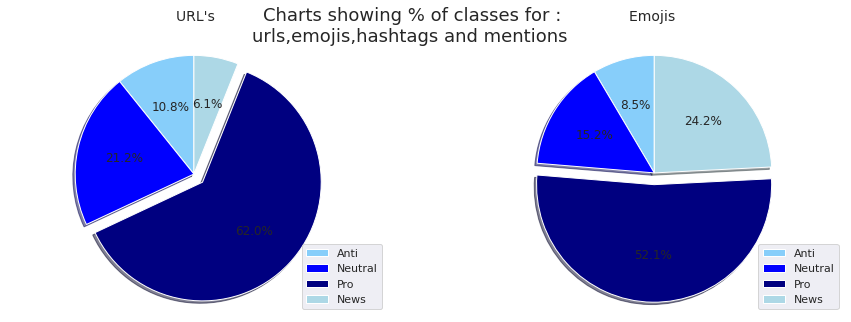

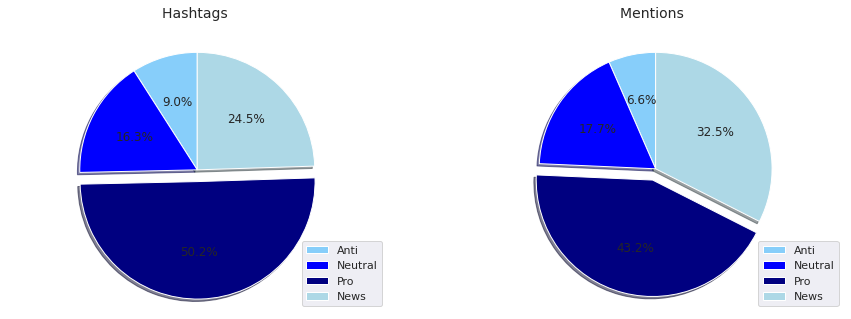

In [28]:
# ploting pie charts for different twitter attributes by classes
anti_u = train_anti.urls.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
neu_u = train_neu.urls.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
pro_u = train_pro.urls.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
news_u = train_news.urls.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()

anti_e = train_anti.emojis.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
neu_e = train_neu.emojis.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
pro_e = train_pro.emojis.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
news_e = train_news.emojis.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()

anti_h = train_anti.hashtags.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
neu_h = train_neu.hashtags.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
pro_h = train_pro.hashtags.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
news_h = train_news.hashtags.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()

anti_m = train_anti.mentions.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
neu_m = train_neu.mentions.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
pro_m = train_pro.mentions.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()
news_m = train_news.mentions.apply(
    lambda x: x if x!=[] else np.NaN).isna().sum()



rcParams['figure.figsize'] = 15, 5
fig1, (ax1,ax2) = plt.subplots(1, 2)
fig2, (ax3,ax4) = plt.subplots(1, 2)
labels = 'Anti', 'Neutral', 'Pro', 'News'
color = ['lightskyblue','blue','navy','lightblue']
explode = (0, 0, 0.1, 0)

fig1.suptitle(f'Charts showing % of classes for :\n'
              f'urls,emojis,hashtags and mentions \n',
              fontsize=18)


ax1.set_title('URL\'s \n',fontsize=14)
sizes_ax1 = [anti_u, neu_u, pro_u, news_u]

ax1.pie(sizes_ax1, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=color)
ax1.axis('equal')
ax1.legend(labels=labels, loc="lower right")

ax2.set_title('Emojis \n',fontsize=14)
sizes_ax2 = [anti_e, neu_e, pro_e, news_e]
ax2.pie(sizes_ax2, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=color)
ax2.axis('equal')
ax2.legend(labels=labels, loc="lower right")


ax3.set_title('Hashtags \n',fontsize=14)
sizes_ax3 = [anti_h, neu_h, pro_h, news_h]
ax3.pie(sizes_ax3, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=color)
ax3.axis('equal')
ax3.legend(labels=labels, loc="lower right")


ax4.set_title('Mentions \n',fontsize=14)
sizes_ax4 = [anti_m, neu_m, pro_m, news_m]
ax4.pie(sizes_ax4, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90,colors=color)
ax4.axis('equal')
ax4.legend(labels=labels, loc="lower right")

plt.show()

To better undersatnd the underlying info we compare the proportions of each twitter attribute in each class to proportions of each class in the dataset:

- From the url pie chart we observe that the proportion of urls in class `Pro` are higher by +10% compared to the proportion of the class, and also url proportion in `News` is much smaller than the proportion of the class in the dataset. This suggests that urls may help our model in predicting this two classes.

- From metions pie chart we observe the oposite of what we observed in the url pie chart, wherein the proportions of mentions in the `Pro`class are less than the proportion of the class in the dataset and visa-versa with regards to `News` class's porportions, suggesting that mentions may help make good predictions.

- There is nothing unsual in the other two pie charts.


#### Length of words and punctuations

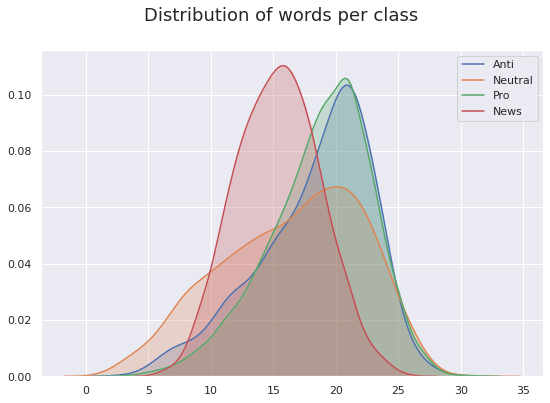

In [29]:
# Ploting distribution by density of words per class

sns.set(rc={'figure.figsize':(9,6)})
suptitle("Distribution of words per class ",fontsize=18)
ax = sns.kdeplot(train_anti.length,label="Anti",shade=True)
ax = sns.kdeplot(train_neu.length,label="Neutral",shade=True)
ax = sns.kdeplot(train_pro.length,label="Pro",shade=True)
ax = sns.kdeplot(train_news.length,label="News",shade=True)

The interesting thing to note here is that distribution of word length in `News` is normally distributed and that it's mean is by about 5 words compared to other classes which have roughly the same mean around 20-21 word length.

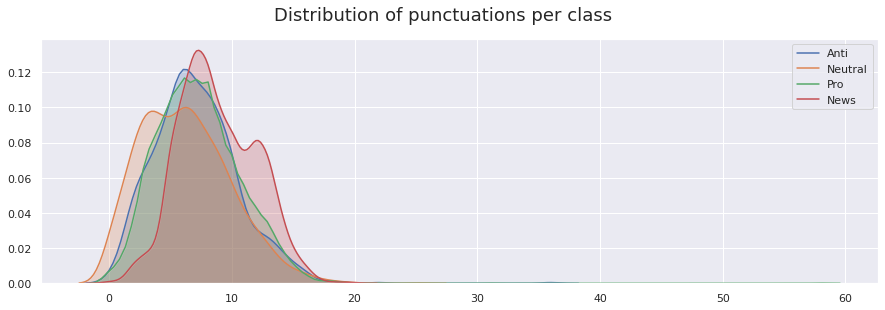

In [30]:


sns.set(rc={'figure.figsize':(15,4.5)})
suptitle("Distribution of punctuations per class ",fontsize=18)

ax = sns.kdeplot(train_anti.punct_num,label="Anti",shade=True)
ax = sns.kdeplot(train_neu.punct_num,label="Neutral",shade=True)
ax = sns.kdeplot(train_pro.punct_num,label="Pro",shade=True)
ax = sns.kdeplot(train_news.punct_num,label="News",shade=True)

From the plot we observe that the mean for all classes is around 7-8 number of punctions per tweet which is not out of the ordinary, however we also observe that although the minimum and mean of the classes are similar the maximum number of punctuations for each class differ greatly. It is hard to day wheather or not this could help in predictions since it is very few dat points or tweets that excced 20 punctuation.

In [31]:
print('\t~ Closer inspection of number of punctuations per class ~\n')
print(f'Anti:\n\tmin~{train_anti.punct_num.min()}\tmax~{train_anti.punct_num.max()}')
print(f'Neautral:\n\tmin~{train_neu.punct_num.min()}\tmax~{train_neu.punct_num.max()}')
print(f'Pro:\n\tmin~{train_pro.punct_num.min()}\tmax~{train_pro.punct_num.max()}')
print(f'News:\n\tmin~{train_news.punct_num.min()}\tmax~{train_news.punct_num.max()}')

	~ Closer inspection of number of punctuations per class ~

Anti:
	min~0	max~36
Neautral:
	min~0	max~25
Pro:
	min~0	max~58
News:
	min~0	max~20


#### Common and Frequent words

For observing and exploring common/frequent words we need to remove stopwords and punctuations.

In [32]:
def stopword_remover(tweet):
    words = word_tokenize(tweet)
    punct_list = ['!', '"', '#', '$', '%', '&', '\'', '(',
                  ')', '*', '+', ',', '-', '.', '/', ':',
                  ';', '<', '=', '>', '?', '@', '[', '\\',
                  ']', '^', '_', '`', '{', '|', '}', '~',
                  '``',"''",'...','\'-']
    
    StopWords = set(stopwords.words('english')+punct_list)
    wordsFiltered=[]
    for w in words:
        if w not in StopWords:
            wordsFiltered.append(w)
        else:
            continue
    return wordsFiltered

In [37]:
# Removing stopwords + punctuations from data 
anti_temp = train_anti.message.apply(lambda x: stopword_remover(str(x)))
neu_temp = train_neu.message.apply(lambda x: stopword_remover(str(x)))
pro_temp = train_pro.message.apply(lambda x: stopword_remover(str(x)))
news_temp = train_news.message.apply(lambda x: stopword_remover(str(x)))

In [38]:
# Frequent and common words for Neutral
count_neu = Counter([item for list_ in neu_temp for item in list_])
top_neu = pd.DataFrame(count_neu.most_common(20),columns=['words','count'])
top_neu.style.background_gradient(cmap='Blues')

,words,count
0,climate,1379
1,change,1378
2,RT,1068
3,global,987
4,warming,972
5,https,888
6,I,388
7,'s,363
8,n't,238
9,Trump,133


In [39]:
# Frequent and common words for Pro
count_pro = Counter([item for list_ in pro_temp for item in list_])
top_pro = pd.DataFrame(count_pro.most_common(20),columns=['words','count'])
top_pro.style.background_gradient(cmap='Greens')

,words,count
0,climate,6608
1,change,6373
2,RT,5146
3,https,4031
4,global,1529
5,warming,1409
6,'s,1366
7,n't,1031
8,Trump,868
9,I,778


In [40]:
# Frequent and common words for Anti
count_anti = Counter([item for list_ in anti_temp for item in list_])
top_anti = pd.DataFrame(count_anti.most_common(20),columns=['words','count'])
top_anti.style.background_gradient(cmap='Reds')

,words,count
0,change,739
1,climate,693
2,RT,681
3,warming,597
4,global,571
5,https,556
6,'s,184
7,The,149
8,I,143
9,n't,132


In [41]:
# Frequent and common words for News
count_news = Counter([item for list_ in news_temp for item in list_])
top_news = pd.DataFrame(count_news.most_common(20),columns=['words','count'])
top_news.style.background_gradient(cmap='Purples')

,words,count
0,https,4106
1,climate,3250
2,change,3153
3,RT,2129
4,Trump,1035
5,'s,499
6,global,480
7,warming,420
8,’,374
9,The,283


#### Word Cloud

In [ ]:
def plot_wordcloud(text, mask=None, max_words=500, max_font_size=90,
                   figure_size=(10.0,10.0), title = None, title_size=40,
                   image_color=False):
    
    punct_list = ['!', '"', '#', '$', '%', '&', '\'', '(',
                  ')', '*', '+', ',', '-', '.', '/', ':',
                  ';', '<', '=', '>', '?', '@', '[', '\\',
                  ']', '^', '_', '`', '{', '|', '}', '~',
                  '``',"''",'...','\'-']    
    
    stopWords = set(stopwords.words('english')+punct_list)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopWords = stopWords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopWords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 

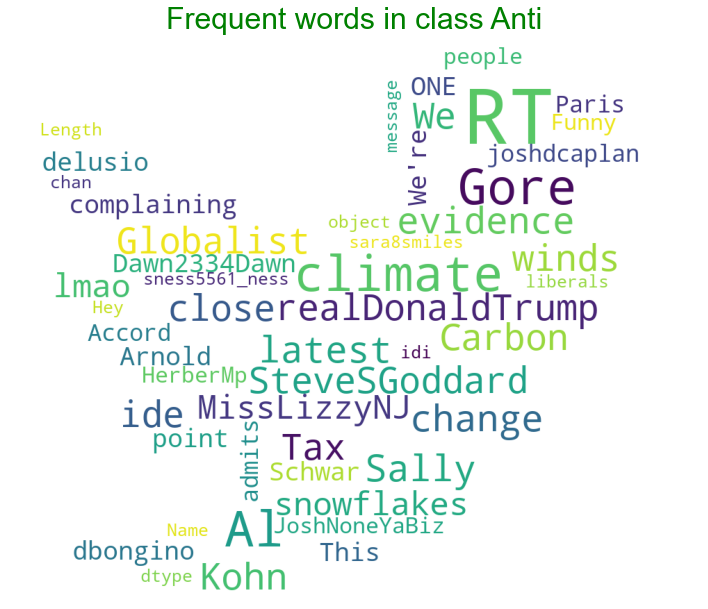

In [ ]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(str(train_anti.message),mask=pos_mask,max_font_size=110,
               title_size=30,title="Frequent words in class Anti")


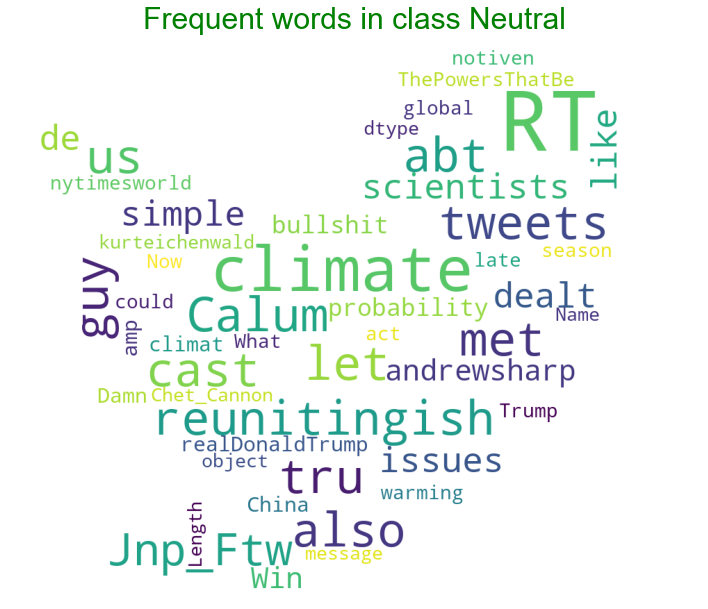

In [ ]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(str(train_neu.message),mask=pos_mask,max_font_size=120,
               title_size=30,title="Frequent words in class Neutral")


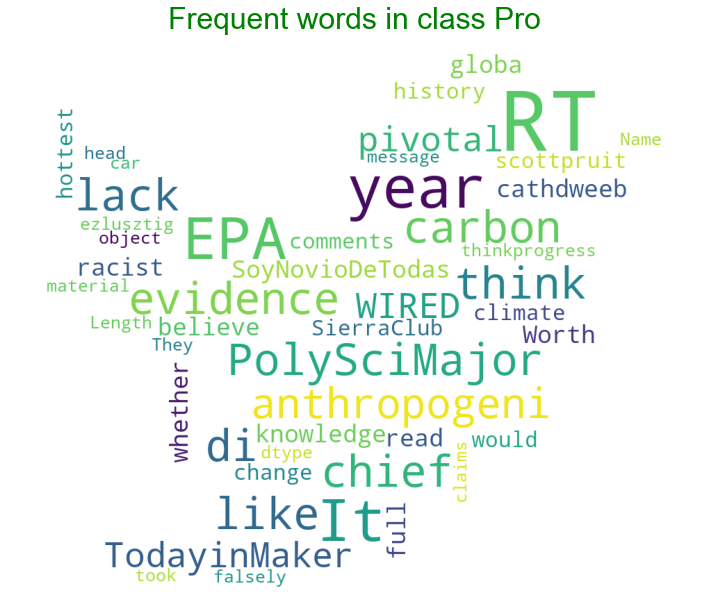

In [ ]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(str(train_pro.message),mask=pos_mask,max_font_size=120,
               title_size=30,title="Frequent words in class Pro")


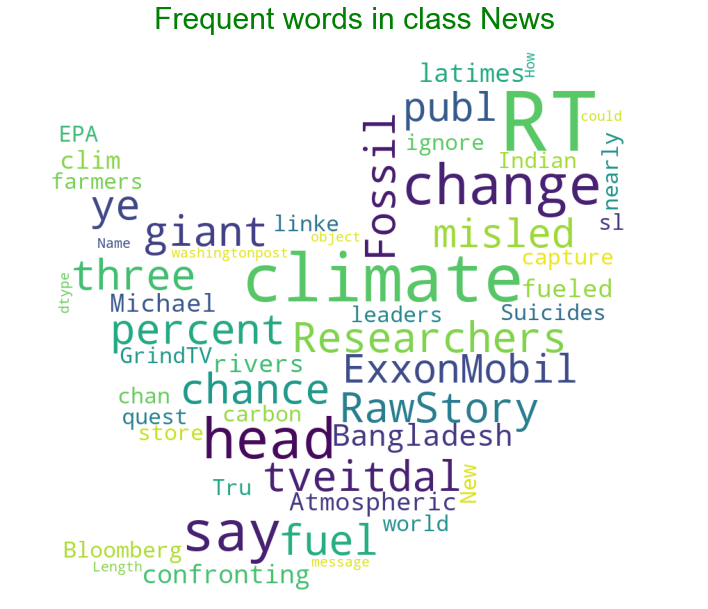

In [ ]:
pos_mask = np.array(Image.open('twitter_mask.png'))
plot_wordcloud(str(train_news.message),mask=pos_mask,max_font_size=120,title_size=30,title="Frequent words in class News")


### EDA Conclusion

Summarising what we learned or observed in our exporitory data analysis:
- The Train data is unbalanced with the `Pro` class having the most datapoints. We need to look into finding ways to making the data balanced so to avoid the <a href="https://en.wikipedia.org/wiki/Accuracy_paradox">Accuracy paradox</a>. One solution is to remove a portion retweeted tweets from the class.
- Our train data has 694 duplicates.
- Keeping urls and @mentions and removing hashtags and emojis might help our model predict better.
- The length of words in a tweet could help better classify the class `News`
- In the common words section we observed that the USA presidents name 'Trump' appears in the top 20 of every class as well as the the country name itself appearing on a couple class's common words list. This coupled with the fact that on the word clouds a few US celebrities and politicians and media pesonalities suggests that ost if not of these tweets come from twitter users based in the US.

___

## Data Preprocessing, Feature Selection and Feature Engineering

Data preprocessing is all about taking the information and insights learnt in EDA and and applying it, esentially making your data ready to be taken in by your model and make predictions by selecting features that are optimal for your model. 

Since the train data is imbalanced we are going to train or evaluate our model on three differently selected features that is:
- The first set of features will be onces were not oversampled or undersampled
- Second set of features will be oversampled
- Final set of of features will be undersampled

In [42]:
df_test = test_df.copy()

In [43]:
# Finds emoji's in a tweet
def find_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emo = re.findall(emoji_pattern, text)
    return ''.join(emo)

# Removes punctuation in text or message
def punct_remover(tweet):
    words = word_tokenize(tweet)
    punct_list = ['!', '"', '#', '$', '%', '&', '\'', '(',
                  ')', '*', '+', ',', '-', '.', '/', ':',
                  ';', '<', '=', '>', '?', '@', '[', '\\',
                  ']', '^', '_', '`', '{', '|', '}', '~',
                  '``',"''",'...','\'-']
    
    punct = set(punct_list)
    Filtered=[]
    for w in words:
        if w not in punct:
            Filtered.append(w)
        else:
            continue
    return ' '.join(Filtered)

In [44]:
### first set of features

# Applying that remove punctuation,emojis and hashtags
df_train['message']=df_train['message'].apply(lambda x: re.sub(r'(?<=#)\w+','',x))
df_train['message']=df_train['message'].apply(lambda x: re.sub(find_emoji(x),'',x))
df_train.message = df_train.message.apply(lambda x: punct_remover(str(x)))

# Applying that remove punctuation,emojis and hashtags
df_test['message']=df_test['message'].apply(lambda x: re.sub(r'(?<=#)\w+','',x))
df_test['message']=df_test['message'].apply(lambda x: re.sub(find_emoji(x),'',x))
df_test.message = df_test.message.apply(lambda x: punct_remover(str(x)))

In [45]:
vectorizer1 = TfidfVectorizer(min_df=2,max_df=0.95)
X = df_train.message
y = df_train.sentiment
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25,
                                                        random_state=42)

In [46]:
X_train1 = vectorizer1.fit_transform(X_train1)
X_test1 = vectorizer1.transform(X_test1)

In [47]:
### Seocond set of features
vectorizer2 = TfidfVectorizer(min_df=2,max_df=0.95)
X = vectorizer2.fit_transform(X)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [48]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X_res, y_res,
                                                     test_size=0.25,
                                                     random_state=42)

In [49]:
### Third set of features

tp =train_pro[train_pro.message.apply(lambda x:re.search(r"\S?RT",x) != None)]
third_feature = df_train.drop([list(tp.index)][0])

In [50]:
vectorizer = TfidfVectorizer(min_df=2,max_df=0.95)
X = third_feature.message
y = third_feature.sentiment
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.25,
                                                        random_state=42)

In [51]:
X_train3 = vectorizer.fit_transform(X_train3)
X_test3 = vectorizer.transform(X_test3)

___

## Model Building

### Library Imports for model building

The important metric to note is the f1-score (macro avg) since its the
metric used on kaggle for scoring. The score obtained on the notebook will
not be the same as the one to be obtained on kaggle.The score on the notebook is helpful on gauging 
your margins and comparing different models on the notebook.

In [52]:
names = ['multiNB', 'KNN',
         'LinearSVC', 'SVM',
         'AdaBoost']

In [53]:
classifiers = [
    MultinomialNB(),
    KNeighborsClassifier(),
    LinearSVC(),
    SVC(),
    AdaBoostClassifier()
]

In [54]:
results1 = []

models1 = {}
confusion1 = {}
class_report1 = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train1, y_train1)

    print ('... predicting')
    y_pred = clf.predict(X_test1)

    print ('... scoring')
    accuracy  = accuracy_score(y_test1, y_pred)
    precision = precision_score(y_test1, y_pred,average='macro')
    recall    = recall_score(y_test1, y_pred,average='macro')

    f1_test   = f1_score(y_test1, y_pred,average='macro')

    # Save the results to dictionaries
    models1[name] = clf
    confusion1[name] = confusion_matrix(y_test1, y_pred)
    class_report1[name] = classification_report(y_test1, y_pred)

    results1.append([name, accuracy, precision, recall, f1_test, run_time.best])


results1 = pd.DataFrame(results1, columns=['Classifier', 'Accuracy',
                                           'Precision', 'Recall', 'F1 Test',
                                           'Train Time'])
results1.set_index('Classifier', inplace= True)

Fitting multiNB model...
... predicting
... scoring
Fitting KNN model...
... predicting
... scoring
Fitting LinearSVC model...
... predicting
... scoring
Fitting SVM model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring


In [55]:
results1

,Accuracy,Precision,Recall,F1 Test,Train Time
Classifier,,,,,
multiNB,0.661819,0.848730,0.416992,0.423401,0.005046
KNN,0.625859,0.554599,0.537005,0.542899,0.002151
LinearSVC,0.728451,0.687868,0.625828,0.648965,0.196801
SVM,0.733474,0.782808,0.567017,0.609465,31.126194
AdaBoost,0.636436,0.622652,0.491727,0.522605,1.556593


In [56]:
results2 = []

models2 = {}
confusion2 = {}
class_report2 = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train2, y_train2)

    print ('... predicting')
    y_pred = clf.predict(X_test2)

    print ('... scoring')
    accuracy  = accuracy_score(y_test2, y_pred)
    precision = precision_score(y_test2, y_pred,average='macro')
    recall    = recall_score(y_test2, y_pred,average='macro')

    f1_test   = f1_score(y_test2, y_pred,average='macro')

    # Save the results to dictionaries
    models2[name] = clf
    confusion2[name] = confusion_matrix(y_test2, y_pred)
    class_report2[name] = classification_report(y_test2, y_pred)

    results2.append([name, accuracy, precision, recall, f1_test, run_time.best])
    
results2 = pd.DataFrame(results2, columns=['Classifier', 'Accuracy',
                                           'Precision', 'Recall', 'F1 Test',
                                           'Train Time'])
results2.set_index('Classifier', inplace= True)

Fitting multiNB model...
... predicting
... scoring
Fitting KNN model...
... predicting
... scoring
Fitting LinearSVC model...
... predicting
... scoring
Fitting SVM model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring


In [57]:
results2

,Accuracy,Precision,Recall,F1 Test,Train Time
Classifier,,,,,
multiNB,0.811191,0.810280,0.813160,0.808163,0.009778
KNN,0.728842,0.786189,0.734148,0.664278,0.003616
LinearSVC,0.880091,0.880161,0.881718,0.878319,0.469012
SVM,0.903439,0.912829,0.903716,0.906010,104.348279
AdaBoost,0.608679,0.607502,0.610121,0.604821,4.800671


In [58]:
results3 = []

models3 = {}
confusion3 = {}
class_report3 = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train3, y_train3)

    print ('... predicting')
    y_pred = clf.predict(X_test3)

    print ('... scoring')
    accuracy  = accuracy_score(y_test3, y_pred)
    precision = precision_score(y_test3, y_pred,average='macro')
    recall    = recall_score(y_test3, y_pred,average='macro')

    f1_test   = f1_score(y_test3, y_pred,average='macro')

    # Save the results to dictionaries
    models3[name] = clf
    confusion3[name] = confusion_matrix(y_test3, y_pred)
    class_report3[name] = classification_report(y_test3, y_pred)

    results3.append([name, accuracy, precision, recall, f1_test, run_time.best])


results3 = pd.DataFrame(results3, columns=['Classifier', 'Accuracy',
                                           'Precision', 'Recall', 'F1 Test',
                                           'Train Time'])
results3.set_index('Classifier', inplace= True)

Fitting multiNB model...
... predicting
... scoring
Fitting KNN model...
... predicting
... scoring
Fitting LinearSVC model...
... predicting
... scoring
Fitting SVM model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring


In [59]:
results3

,Accuracy,Precision,Recall,F1 Test,Train Time
Classifier,,,,,
multiNB,0.683727,0.743274,0.590645,0.592934,0.003639
KNN,0.602559,0.579831,0.569399,0.570690,0.001173
LinearSVC,0.740104,0.727344,0.691158,0.702933,0.113567
SVM,0.739704,0.750967,0.667062,0.680590,13.229438
AdaBoost,0.598960,0.550796,0.530943,0.532981,0.982038


In [ ]:
print(class_report3['LinearSVC'])
print(class_report['LinearSVC'])

              precision    recall  f1-score   support

          -1       0.74      0.51      0.60       326
           0       0.65      0.61      0.63       570
           1       0.69      0.74      0.72       701
           2       0.82      0.90      0.86       904

    accuracy                           0.74      2501
   macro avg       0.73      0.69      0.70      2501
weighted avg       0.74      0.74      0.73      2501

              precision    recall  f1-score   support

          -1       0.71      0.47      0.57       319
           0       0.54      0.43      0.48       557
           1       0.77      0.84      0.80      2004
           2       0.74      0.76      0.75       902

    accuracy                           0.73      3782
   macro avg       0.69      0.63      0.65      3782
weighted avg       0.72      0.73      0.72      3782



Taking the best model for each of the three set of features chosen for modeling, fitting them in a pipeline tunning each model to its optimal.

In [67]:
LSVC = LinearSVC()
svc = SVC()

In [71]:
# Feature set 1
LSVC.fit(X_train1, y_train1)
lsvc_pred = LSVC.predict(vectorizer1.transform(df_test.message))

In [73]:
lsvc1 = pd.DataFrame({'tweetid': df_test.index, 
                           'sentiment': lsvc_pred})
lsvc1

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,0
10542,875167,1
10543,78329,1
10544,867455,0


In [81]:
# Saving to .csv file
lsvc1.to_csv('lsvc1.csv',index = False)

In [76]:
# Feature set 2
svc.fit(X_train2, y_train2)
support_pred = svc.predict(vectorizer2.transform(df_test.message))

In [77]:
svc = pd.DataFrame({'tweetid': df_test.index, 
                           'sentiment': support_pred})
svc

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1
...,...,...
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0


In [82]:
# Saving to .csv file
svc.to_csv('svc.csv',index = False)

In [79]:
# Feature set 3
LSVC.fit(X_train3,y_train3)
lsvc_pred3 = LSVC.predict(vectorizer.transform(df_test.message))

In [80]:
lsvc3 = pd.DataFrame({'tweetid': df_test.index, 
                           'sentiment': lsvc_pred3})
lsvc3

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,0
10542,875167,1
10543,78329,2
10544,867455,0


In [83]:
# Saving to .csv file
lsvc3.to_csv('lsvc3.csv',index = False)

In [ ]:
model_save_path = 'RandomForest_boosted_01.pkl'
with open(model_save_path,'wb') as file:
    pickle.dump(boosted_pipe,file)

### <font color=blue>End Experiment

In [ ]:
experiment.end()

experiment.display()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/shyken/general/49683782d19b4d558e999aa6c5590bfd
COMET INFO:   Parameters [count]:
COMET INFO:     KNN_algorithm                : auto
COMET INFO:     KNN_leaf_size                : 30
COMET INFO:     KNN_metric                   : minkowski
COMET INFO:     KNN_metric_params            : 1
COMET INFO:     KNN_n_jobs                   : 1
COMET INFO:     KNN_n_neighbors              : 10
COMET INFO:     KNN_p                        : 2
COMET INFO:     KNN_weights                  : uniform
COMET INFO:     RFC_bootstrap [2]            : 2
COMET INFO:     RFC_ccp_alpha                : 1
COMET INFO:     RFC_class_weight             : 1
COMET INFO:     RFC_criterion                : gini
COMET INFO:     RFC_max_depth [2]            : 60
COMET INFO:    